## Figure SX code
Elena Savidge
<br>
29 May 2025

In [3]:
# # load packages
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
import cmocean
import scipy
from scipy import ndimage
import cartopy.crs as ccrs
import cartopy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import rasterio
from rasterio.plot import show
import pyproj
from pyproj import Proj, transform, CRS
#import rioxarray as rxr
import geopandas as gpd
import datetime
from osgeo import gdal
from shapely.geometry import Point, Polygon
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import geopandas as gpd
from skimage import exposure
import pandas as pd
import matplotlib.pyplot as plt
import datetime

/opt/anaconda3/envs/polyarea/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [4]:
# need this line for pyproj to work
pyproj.datadir.set_data_dir('/opt/anaconda3/envs/polyarea/share/proj') 

## Read in grounding line

In [5]:
# Define your points and create a bounding box polygon
p1 = Point(-110, -70.5)
p2 = Point(-111.7, -75.4)
p3 = Point(-98.0, -75.4)
p4 = Point(-99.5, -70.5)

# Define the bounding box CRS
crs = "EPSG:4326"  # Adjust this based on your data's CRS
bb_polygon = Polygon([p1, p2, p3, p4])
map_extent = gpd.GeoDataFrame(geometry=[bb_polygon], crs=crs)

# Read in the coastline with a defined CRS
coastline = '../add_coastline_high_res_line_v7_4.shp'  #version 7.4 is updated
shelf = gpd.read_file(coastline)

# Make sure both GeoDataFrames have the same CRS
shelf = shelf.to_crs(crs)

# Check the intersection
intersection = map_extent.intersects(shelf.unary_union)
print("Intersection:", intersection)

# Clip with the same CRS
shelf_clip = gpd.clip(shelf, map_extent)
shelf_clip = shelf_clip[~shelf_clip.is_empty]
# land = shelf_clip.loc[shelf_clip['surface'] == 'land']
# ice = shelf_clip.loc[shelf_clip['surface'] == 'ice shelf']
GL = shelf_clip.loc[shelf_clip['surface'] == 'grounding line']

# Print lengths to verify
print("Length of original shelf:", len(shelf))
print("Length of clipped shelf:", len(shelf_clip))
# print("Length of land:", len(land))
# print("Length of ice:", len(ice))
print("Length of GL:", len(GL))

Intersection: 0    True
dtype: bool
Length of original shelf: 30663
Length of clipped shelf: 212
Length of GL: 43


### To resolve issue with new Sentinel-2 data download missing crs (get it from old image --> same tile = same bounds = same CRS)

Sentinel-2 data can be downloaded here:
https://browser.dataspace.copernicus.eu/?zoom=5&lat=50.16282&lng=20.78613&themeId=DEFAULT-THEME&visualizationUrl=U2FsdGVkX1%2FmHIsPn%2BXfhahaj9BRImmmIj6RspyvyEGGPZYgr34W6V7S9eb7KcDgIMNjtxwzdQd4RherUl%2FUPX1PoVy%2B7SqkUalH2N4roxDWsDceAsFiuEdOigdhU1jy&datasetId=S2_L2A_CDAS&demSource3D=%22MAPZEN%22&cloudCoverage=30&dateMode=SINGLE

### scene 2018/03/07

In [6]:
# Specify the path to a Sentinel-2 band file (e.g., B04 for red band)
band_path = '../PIG_sentinel2/20180307/S2B_MSIL1C_20180307T145249_N0206_R053_T14CMB_20180307T191420-ql.jpg'

# Open the band file
with rasterio.open(band_path) as dataset:
    # Get the CRS information
    crs_info = dataset.crs

# Print the CRS information
print("CRS Info:")
print(crs_info)

CRS Info:
None


/opt/anaconda3/envs/polyarea/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [7]:
# file crs works but not rr--- exact same image tile so crs is the same

file_path = '../PIG_sentinel2/L1C_T14CMB_A015809_20200316T145252.tif'

# Normalize each band independently
def normalize_band(band):
    band_min = band.min()
    band_max = band.max()
    return ((band - band_min) / (band_max - band_min) * 255).astype('uint8')

# Open the single band
with rasterio.open(file_path) as file:
    # Read each band
    red_band = file.read(1)
    green_band = file.read(2)
    blue_band = file.read(3)

## scene 1: 2017.10.13

In [8]:
# sentinel2: blue (B2), green (B3), red (B4)

red_path= '../PIG_sentinel2/20171013/T14CMB_20171013T145251_B04.jp2'
green_path= '../PIG_sentinel2/20171013/T14CMB_20171013T145251_B03.jp2'
blue_path= '../PIG_sentinel2/20171013/T14CMB_20171013T145251_B02.jp2'

# Normalize each band independently
def normalize_band(band):
    band_min = band.min()
    band_max = band.max()
    return ((band - band_min) / (band_max - band_min) * 255).astype('uint8')

# Open the single band
with rasterio.open(red_path) as rr, rasterio.open(green_path) as gg, rasterio.open(blue_path) as bb:
    # Read each band
    red_band = rr.read(1)
    green_band = gg.read(1)
    blue_band = bb.read(1)

    # Normalize each band
    red_band_normalized = normalize_band(red_band)
    green_band_normalized = normalize_band(green_band)
    blue_band_normalized = normalize_band(blue_band)

    # Stack the bands into an RGB image
    rgb_image = np.dstack((red_band_normalized, green_band_normalized, blue_band_normalized))

    # Get the geospatial transformation matrix
    transform = file.transform  # Assumes all bands share the same transform

    # Specify the South Polar Stereographic projection
    projection = ccrs.SouthPolarStereo(central_longitude=-99.0)  #get central lon from metadata

    # Calculate the geographic coordinates of the four corners
    width, height = file.width, file.height
    upper_left = transform * (0, 0)
    upper_right = transform * (width, 0)
    lower_left = transform * (0, height)
    lower_right = transform * (width, height)

    # Get corners in the desired projection
    ul_lon, ul_lat = projection.transform_point(upper_left[0], upper_left[1], file.crs)
    ur_lon, ur_lat = projection.transform_point(upper_right[0], upper_right[1], file.crs)
    ll_lon, ll_lat = projection.transform_point(lower_left[0], lower_left[1], file.crs)
    lr_lon, lr_lat = projection.transform_point(lower_right[0], lower_right[1], file.crs)


In [9]:
# More moderate contrast stretching (e.g., 2nd and 98th percentiles)
def contrast_stretching(image):
    p2, p98 = np.percentile(image, (2, 98))
    return exposure.rescale_intensity(image, in_range=(p2, p98))

# Gentle gamma correction (gamma < 1 brightens the image)
def gamma_correction(image, gamma=0.5):
    return exposure.adjust_gamma(image, gamma)

# Apply to each channel
red_band_stretched = contrast_stretching(rgb_image[:, :, 0])
green_band_stretched = contrast_stretching(rgb_image[:, :, 1])
blue_band_stretched = contrast_stretching(rgb_image[:, :, 2])

red_band_corrected = gamma_correction(red_band_stretched)
green_band_corrected = gamma_correction(green_band_stretched)
blue_band_corrected = gamma_correction(blue_band_stretched)

# Stack the corrected channels
rgb_image_bright = np.stack((red_band_corrected, green_band_corrected, blue_band_corrected), axis=-1)

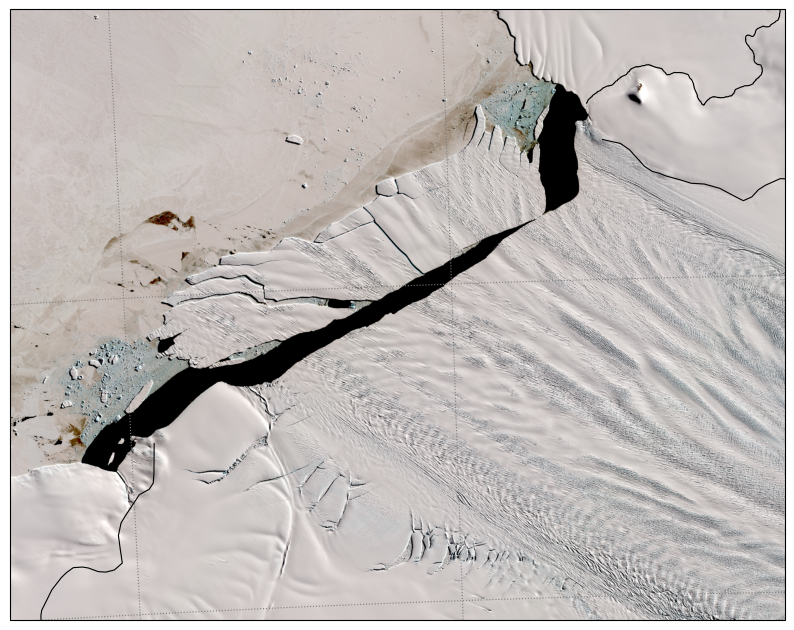

In [10]:
llcrnrlat=-75.25;urcrnrlat=-74.79;llcrnrlon=-102.3;urcrnrlon=-100

# Create the plot with the specified CRS
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# Set the extent of the plot
ax.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], crs=ccrs.PlateCarree())

# Display the Landsat image with enhanced properties
data0 = ax.imshow(rgb_image_bright, 
                  extent=(ll_lon, ur_lon, ll_lat, ur_lat), 
                  origin='upper', 
                  transform=projection)
# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs=[-102, -101], ylocs=[-75, -75.25], color='grey', linestyle=':',linewidth=0.8)

# Add the grounding line to the plot
ax.add_geometries(GL['geometry'], 
                  crs=ccrs.PlateCarree(), 
                  facecolor='None', 
                  edgecolor='k', 
                  zorder=3,linewidth=0.8)

# # Add a scale bar
# fontprops = fm.FontProperties(size=20)
# scalebar = AnchoredSizeBar(ax.transData,
#                            10000, '10 km', 'lower left',
#                            pad=0.5,
#                            color='k',
#                            frameon=False,
#                            size_vertical=250,
#                            fill_bar=True,
#                            sep=3.5,
#                            fontproperties=fontprops)
# ax.add_artist(scalebar)

# Turn off axis visibility if needed
# ax.axis('off')

# Show the plot or save it as a PNG file
# plt.show()
#plt.savefig('20171013sent2.png', format='png', dpi=400)


## scene 2: 2018.11.18

In [11]:
# sentinel2: blue (B2), green (B3), red (B4)

red_path= '../PIG_sentinel2/20181118/T14CMB_20181118T151259_B04.jp2'
green_path= '../PIG_sentinel2/20181118/T14CMB_20181118T151259_B03.jp2'
blue_path= '../PIG_sentinel2/20181118/T14CMB_20181118T151259_B02.jp2'

# Normalize each band independently
def normalize_band(band):
    band_min = band.min()
    band_max = band.max()
    return ((band - band_min) / (band_max - band_min) * 255).astype('uint8')

# Open the single band
with rasterio.open(red_path) as rr, rasterio.open(green_path) as gg, rasterio.open(blue_path) as bb:
    # Read each band
    red_band = rr.read(1)
    green_band = gg.read(1)
    blue_band = bb.read(1)

    # Normalize each band
    red_band_normalized = normalize_band(red_band)
    green_band_normalized = normalize_band(green_band)
    blue_band_normalized = normalize_band(blue_band)

    # Stack the bands into an RGB image
    rgb_image = np.dstack((red_band_normalized, green_band_normalized, blue_band_normalized))

    # Get the geospatial transformation matrix
    transform = file.transform  # Assumes all bands share the same transform

    # Specify the South Polar Stereographic projection
    projection = ccrs.SouthPolarStereo(central_longitude=-99.0)  #get central lon from metadata

    # Calculate the geographic coordinates of the four corners
    width, height = file.width, file.height
    upper_left = transform * (0, 0)
    upper_right = transform * (width, 0)
    lower_left = transform * (0, height)
    lower_right = transform * (width, height)

    # Get corners in the desired projection
    ul_lon, ul_lat = projection.transform_point(upper_left[0], upper_left[1], file.crs)
    ur_lon, ur_lat = projection.transform_point(upper_right[0], upper_right[1], file.crs)
    ll_lon, ll_lat = projection.transform_point(lower_left[0], lower_left[1], file.crs)
    lr_lon, lr_lat = projection.transform_point(lower_right[0], lower_right[1], file.crs)


In [12]:
# More moderate contrast stretching (e.g., 2nd and 98th percentiles)
def contrast_stretching(image):
    p2, p98 = np.percentile(image, (2, 98))
    return exposure.rescale_intensity(image, in_range=(p2, p98))

# Gentle gamma correction (gamma < 1 brightens the image)
def gamma_correction(image, gamma=1):
    return exposure.adjust_gamma(image, gamma)

# Apply to each channel
red_band_stretched = contrast_stretching(rgb_image[:, :, 0])
green_band_stretched = contrast_stretching(rgb_image[:, :, 1])
blue_band_stretched = contrast_stretching(rgb_image[:, :, 2])

red_band_corrected = gamma_correction(red_band_stretched)
green_band_corrected = gamma_correction(green_band_stretched)
blue_band_corrected = gamma_correction(blue_band_stretched)

# Stack the corrected channels
rgb_image_bright = np.stack((red_band_corrected, green_band_corrected, blue_band_corrected), axis=-1)


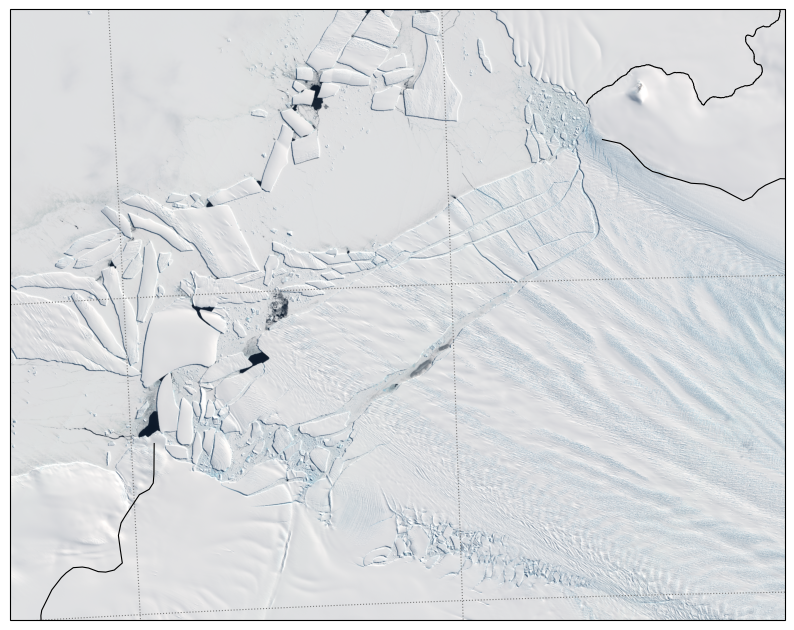

In [13]:
llcrnrlat=-75.25;urcrnrlat=-74.79;llcrnrlon=-102.3;urcrnrlon=-100

# Create the plot with the specified CRS
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# Set the extent of the plot
ax.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], crs=ccrs.PlateCarree())

# Display the Landsat image with enhanced properties
data0 = ax.imshow(rgb_image_bright, 
                  extent=(ll_lon, ur_lon, ll_lat, ur_lat), 
                  origin='upper', 
                  transform=projection)
# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs=[-102, -101], ylocs=[-75, -75.25], color='grey', linestyle=':',linewidth=0.8)

# Add the grounding line to the plot
ax.add_geometries(GL['geometry'], 
                  crs=ccrs.PlateCarree(), 
                  facecolor='None', 
                  edgecolor='k', 
                  zorder=3,linewidth=0.8)

# # Add a scale bar
# fontprops = fm.FontProperties(size=18)
# scalebar = AnchoredSizeBar(ax.transData,
#                            10000, '10 km', 'lower left',
#                            pad=0.5,
#                            color='k',
#                            frameon=False,
#                            size_vertical=250,
#                            fill_bar=True,
#                            sep=3.5,
#                            fontproperties=fontprops)
# ax.add_artist(scalebar)

# Turn off axis visibility if needed
# ax.axis('off')

# Show the plot or save it as a PNG file
# plt.show()
#plt.savefig('20181118sent2.png', format='png', dpi=400)


## scene 3: 2020.02.01

In [14]:
# sentinel2: blue (B2), green (B3), red (B4)

red_path= '../PIG_sentinel2/20200201/T14CMB_20200201T151249_B04_10m.jp2'
green_path= '../PIG_sentinel2/20200201/T14CMB_20200201T151249_B03_10m.jp2'
blue_path= '../PIG_sentinel2/20200201/T14CMB_20200201T151249_B02_10m.jp2'

# Normalize each band independently
def normalize_band(band):
    band_min = band.min()
    band_max = band.max()
    return ((band - band_min) / (band_max - band_min) * 255).astype('uint8')

# Open the single band
with rasterio.open(red_path) as rr, rasterio.open(green_path) as gg, rasterio.open(blue_path) as bb:
    # Read each band
    red_band = rr.read(1)
    green_band = gg.read(1)
    blue_band = bb.read(1)

    # Normalize each band
    red_band_normalized = normalize_band(red_band)
    green_band_normalized = normalize_band(green_band)
    blue_band_normalized = normalize_band(blue_band)

    # Stack the bands into an RGB image
    rgb_image = np.dstack((red_band_normalized, green_band_normalized, blue_band_normalized))

    # Get the geospatial transformation matrix
    transform = file.transform  # Assumes all bands share the same transform

    # Specify the South Polar Stereographic projection
    projection = ccrs.SouthPolarStereo(central_longitude=-99.0)  #get central lon from metadata

    # Calculate the geographic coordinates of the four corners
    width, height = file.width, file.height
    upper_left = transform * (0, 0)
    upper_right = transform * (width, 0)
    lower_left = transform * (0, height)
    lower_right = transform * (width, height)

    # Get corners in the desired projection
    ul_lon, ul_lat = projection.transform_point(upper_left[0], upper_left[1], file.crs)
    ur_lon, ur_lat = projection.transform_point(upper_right[0], upper_right[1], file.crs)
    ll_lon, ll_lat = projection.transform_point(lower_left[0], lower_left[1], file.crs)
    lr_lon, lr_lat = projection.transform_point(lower_right[0], lower_right[1], file.crs)


In [15]:
# More moderate contrast stretching (e.g., 2nd and 98th percentiles)
def contrast_stretching(image):
    p2, p98 = np.percentile(image, (2, 98))
    return exposure.rescale_intensity(image, in_range=(p2, p98))

# Gentle gamma correction (gamma < 1 brightens the image)
def gamma_correction(image, gamma=1):
    return exposure.adjust_gamma(image, gamma)

# Apply to each channel
red_band_stretched = contrast_stretching(rgb_image[:, :, 0])
green_band_stretched = contrast_stretching(rgb_image[:, :, 1])
blue_band_stretched = contrast_stretching(rgb_image[:, :, 2])

red_band_corrected = gamma_correction(red_band_stretched)
green_band_corrected = gamma_correction(green_band_stretched)
blue_band_corrected = gamma_correction(blue_band_stretched)

# Stack the corrected channels
rgb_image_bright = np.stack((red_band_corrected, green_band_corrected, blue_band_corrected), axis=-1)


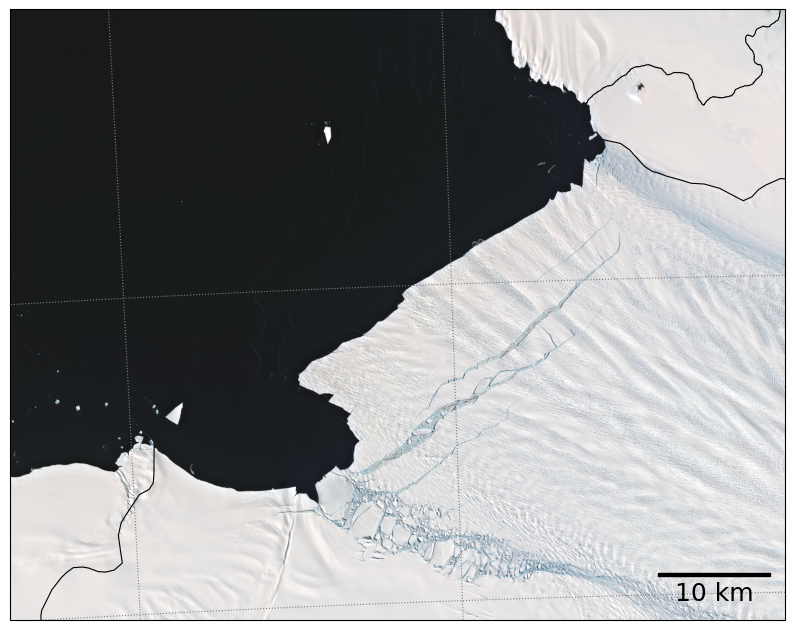

In [16]:
llcrnrlat=-75.25;urcrnrlat=-74.79;llcrnrlon=-102.3;urcrnrlon=-100

# Create the plot with the specified CRS
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# Set the extent of the plot
ax.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], crs=ccrs.PlateCarree())

# Display the Landsat image with enhanced properties
data0 = ax.imshow(rgb_image_bright, 
                  extent=(ll_lon, ur_lon, ll_lat, ur_lat), 
                  origin='upper', 
                  transform=projection)
# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs=[-102, -101], ylocs=[-75, -75.25], color='grey', linestyle=':',linewidth=0.8)

# Add the grounding line to the plot
ax.add_geometries(GL['geometry'], 
                  crs=ccrs.PlateCarree(), 
                  facecolor='None', 
                  edgecolor='k', 
                  zorder=3,linewidth=0.8)

# Add a scale bar
fontprops = fm.FontProperties(size=18)
scalebar = AnchoredSizeBar(ax.transData,
                           10000, '10 km', 'lower right',
                           pad=0.5,
                           color='k',
                           frameon=False,
                           size_vertical=250,
                           fill_bar=True,
                           sep=3.5,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

# Turn off axis visibility if needed
# ax.axis('off')

# Show the plot or save it as a PNG file
# plt.show()
#plt.savefig('20200201sent2.png', format='png', dpi=400)


## Zoom in 

ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT

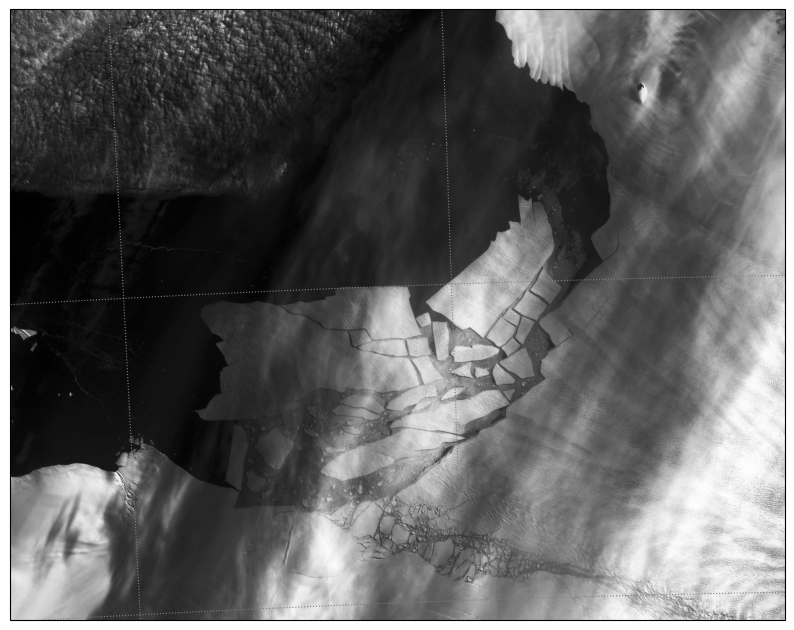

In [18]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from skimage import exposure

# Path to the 3-band RGB GeoTIFF (e.g., exported Sentinel-2)
tiff_path = '../PIG_sentinel2/L1C_T14CMB_A015323_20200211T151254.tif'

# Normalize band to 0–255
def normalize_band(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min) / (band_max - band_min) * 255).astype('uint8')

with rasterio.open(tiff_path) as src:
    # Check band count if unsure; here: 3 bands (B4, B3, B2)
    red_band   = normalize_band(src.read(1))  # Band 1 = B4
    green_band = normalize_band(src.read(2))  # Band 2 = B3
    blue_band  = normalize_band(src.read(3))  # Band 3 = B2

    # Convert to grayscale using standard luminance weights
    grayscale = (0.2989 * red_band + 0.5870 * green_band + 0.1140 * blue_band)

    # Optional: contrast enhancement via histogram equalization
    grayscale_eq = exposure.equalize_hist(grayscale)
    
    # Slight brightness boost with gamma < 1
    grayscale_gamma = exposure.adjust_gamma(grayscale_eq, gamma=0.8)
    grayscale_eq = (grayscale_gamma * 255).astype('uint8')
    #grayscale_eq = (grayscale_eq * 255).astype('uint8')

    # Store metadata
    transform = src.transform
    crs = src.crs
    width, height = src.width, src.height

# Projection
projection = ccrs.SouthPolarStereo(central_longitude=-99.0)

# Calculate corners
upper_left  = transform * (0, 0)
upper_right = transform * (width, 0)
lower_left  = transform * (0, height)
lower_right = transform * (width, height)

# Transform corners to projection CRS
ul_lon, ul_lat = projection.transform_point(*upper_left, crs)
ur_lon, ur_lat = projection.transform_point(*upper_right, crs)
ll_lon, ll_lat = projection.transform_point(*lower_left, crs)
lr_lon, lr_lat = projection.transform_point(*lower_right, crs)

# Set map extent manually (or use corners above)
llcrnrlat = -75.25
urcrnrlat = -74.79
llcrnrlon = -102.3
urcrnrlon = -100.0

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})
ax.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], crs=ccrs.PlateCarree())

# Show grayscale image
ax.imshow(grayscale_eq,
          cmap='gray',
          extent=(ll_lon, ur_lon, ll_lat, ur_lat),
          origin='upper',
          transform=projection)

# # Optional scale bar
# fontprops = fm.FontProperties(size=18)
# scalebar = AnchoredSizeBar(ax.transData,
#                            10000, '10 km', 'lower right',
#                            pad=0.5, color='k', frameon=False,
#                            size_vertical=250, fill_bar=True,
#                            sep=3.5, fontproperties=fontprops)
# ax.add_artist(scalebar)

# Gridlines
gl = ax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(),
                  xlocs=[-102, -101], ylocs=[-75.25, -75],
                  color='grey', linestyle=':', linewidth=0.8)

# Show or save
# plt.show()
#plt.savefig('2020sentinel2postcalve.png', dpi=400, bbox_inches='tight')
